In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import json
import joblib

data = pd.read_csv("S06-hw-dataset-02.csv")

data_head = data.head()
data_describe = data.describe()
target_distribution = data['target'].describe()

print("\nВерхняя часть датафрейма: \n", data_head)
print("\nСводка: \n")
data.info()
print("\nБазовые статистики: \n", data_describe)
print("\nРаспределение таргета: \n", target_distribution)


Верхняя часть датафрейма: 
    id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087   

        f

In [3]:
X = data.drop(columns=['target', 'id'])
y = data['target']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Фиксированный сид важен для воспроизводимости результатов, стратификация нужна для сохранения соотношения классов 

In [45]:
dmb_cls = sklearn.dummy.DummyClassifier(strategy="most_frequent")
lgs_reg = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()), ('log_regression', sklearn.linear_model.LogisticRegression(max_iter=10000, tol=0.1))])
dmb_cls.fit(X_train, y_train)
y_pred_dummy = dmb_cls.predict(X_test)
dummy_metrics = {
    "accuracy": sklearn.metrics.accuracy_score(y_test, y_pred_dummy),
    "f1": sklearn.metrics.f1_score(y_test, y_pred_dummy),
    "roc_auc": 0.5, 
}
print("Метрики DummyClassifier:", dummy_metrics)
print(dmb_cls.score(X_test, y_test))
lgs_reg.fit(X_train, y_train)
print(lgs_reg.score(X_test, y_test))

Метрики DummyClassifier: {'accuracy': 0.7375, 'f1': 0.0, 'roc_auc': 0.5}
0.7375
0.7822222222222223


In [46]:
cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_param_grid = {
    "max_depth": [3, 5, 8],
    "min_samples_leaf": [5, 10, 20]
}

dt_grid = sklearn.model_selection.GridSearchCV(
    sklearn.tree.DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)
dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_
print("Лучшие параметры дерева решений:", dt_grid.best_params_)
print("Лучший f1:", dt_grid.best_score_)

rf_param_grid = {
    "n_estimators": [100],
    "max_depth": [8, 12, None],
    "max_features": ["sqrt", 0.3],
}

rf_grid = sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Лучшие параметры для рандомного леса:", rf_grid.best_params_)
print("Лучший PR-AUC:", rf_grid.best_score_)

hgb_param_grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [4, 6],
    "min_samples_leaf": [20, 30],
}

hgb_grid = sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.HistGradientBoostingClassifier(random_state=42),
    hgb_param_grid,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1
)
hgb_grid.fit(X_train, y_train)

best_hgb = hgb_grid.best_estimator_
print("Лучший HBG:", hgb_grid.best_params_)
print("Лучший PR-AUC:", hgb_grid.best_score_)

Лучшие параметры дерева решений: {'max_depth': 8, 'min_samples_leaf': 10}
Лучший f1: 0.6353644530461204
Лучшие параметры для рандомного леса: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Лучший PR-AUC: 0.863119794658961
Лучший HBG: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 20}
Лучший PR-AUC: 0.8655599291378117


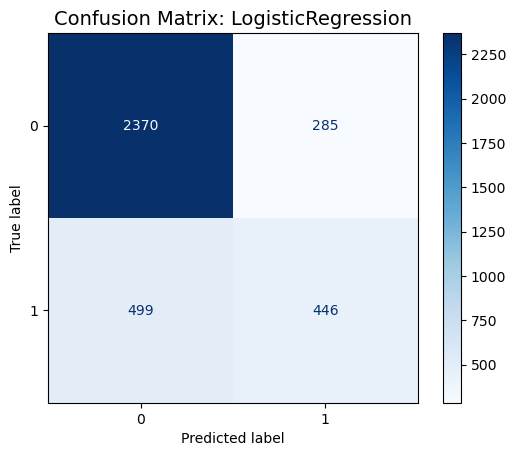

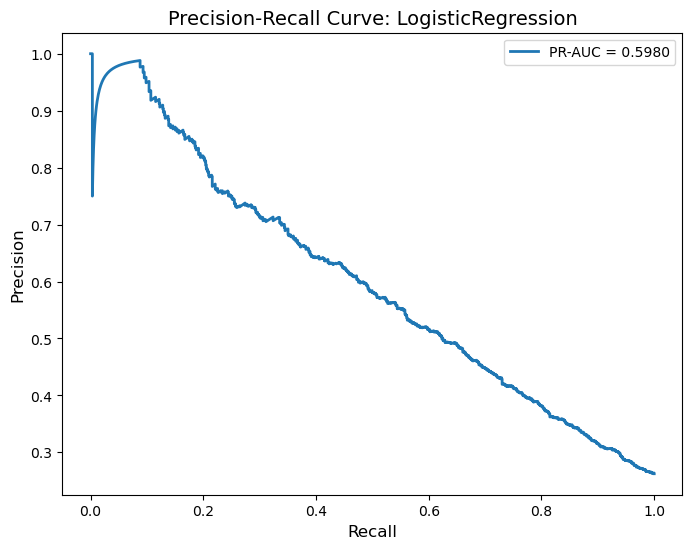

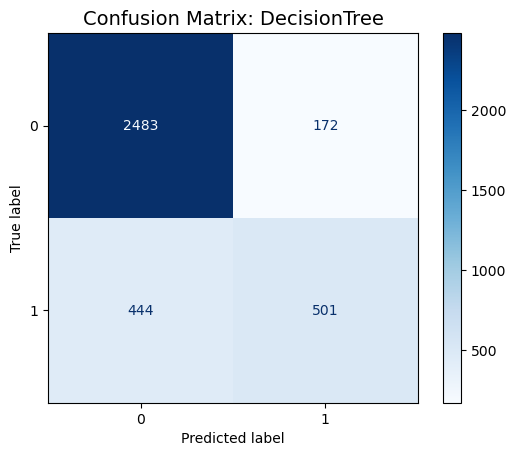

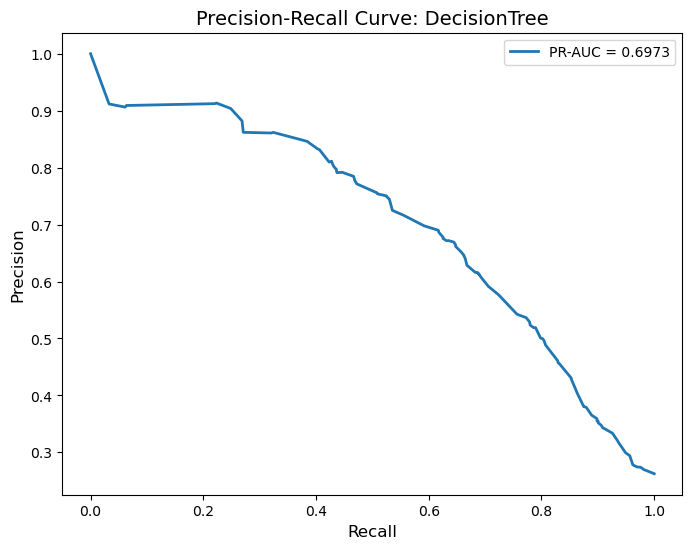

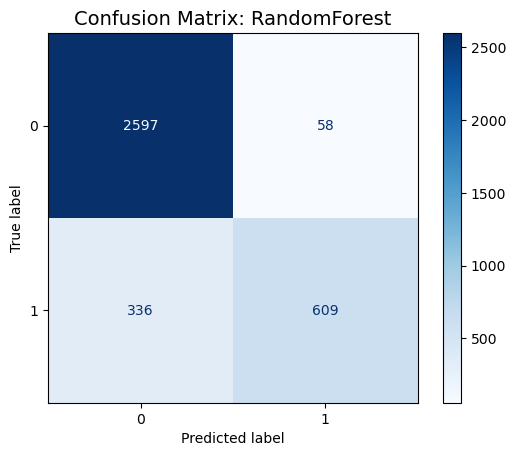

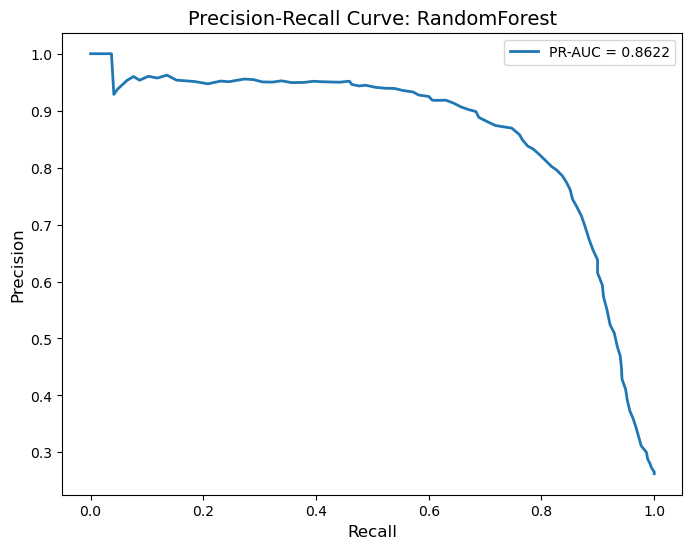

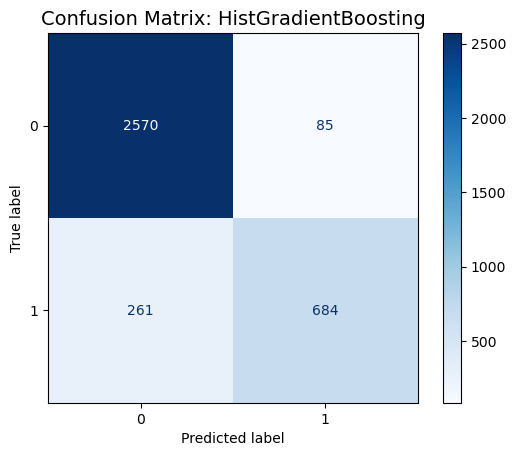

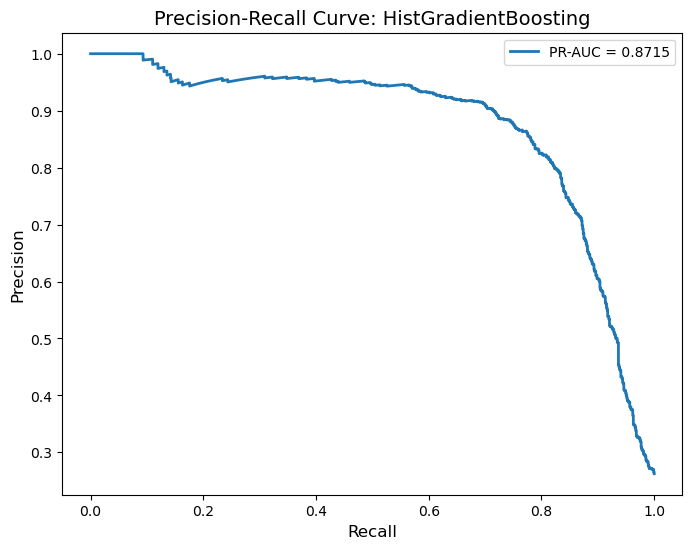

In [55]:
def test_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_pred),
        "f1": sklearn.metrics.f1_score(y_test, y_pred),
        "roc_auc": sklearn.metrics.roc_auc_score(y_test, y_proba),
        "pr_auc": sklearn.metrics.average_precision_score(y_test, y_proba)
    }
    
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}", fontsize=14)
    plt.savefig(f"artifacts/figures/cm_{name}.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, label=f'PR-AUC = {metrics["pr_auc"]:.4f}')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve: {name}', fontsize=14)
    plt.legend(loc='best')
    plt.savefig(f"artifacts/figures/pr_{name}.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    return metrics, y_proba

metrics = {}
probas = {}

metrics["DummyClassifier"] = dummy_metrics
metrics["LogisticRegression"], _ = test_model(lgs_reg, "LogisticRegression")

metrics["DecisionTree"], probas["DecisionTree"] = test_model(best_dt, "DecisionTree")
metrics["RandomForest"], probas["RandomForest"] = test_model(best_rf, "RandomForest")
metrics["HistGradientBoosting"], probas["HistGradientBoosting"] = test_model(best_hgb, "HistGradientBoosting")

In [58]:
best_model_name = max(
    [(name, m["pr_auc"]) for name, m in metrics.items() if name != "DummyClassifier"],
    key=lambda x: x[1]
)[0]
best_model = {
    "LogisticRegression": lgs_reg,
    "DecisionTree": best_dt,
    "RandomForest": best_rf,
    "HistGradientBoosting": best_hgb
}[best_model_name]

print(f"\nЛучшая модель по PR-AUC: {best_model_name}")
print("Тестовые метрики:", metrics[best_model_name])


Лучшая модель по PR-AUC: HistGradientBoosting
Тестовые метрики: {'accuracy': 0.9038888888888889, 'f1': 0.7981330221703618, 'roc_auc': 0.9260538666188383, 'pr_auc': 0.8714698781389206}


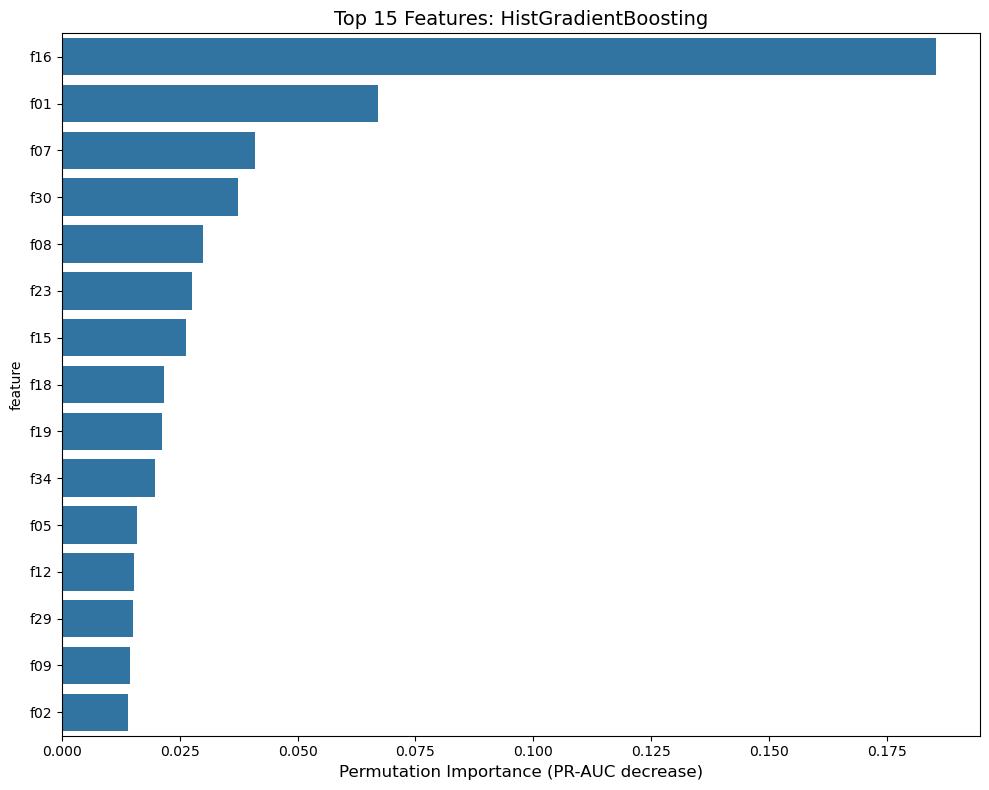

In [65]:
result = sklearn.inspection.permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="average_precision" 
)

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": result.importances_mean,
    "std": result.importances_std
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(
    x="importance", y="feature", data=importance_df,
)
plt.title(f"Top 15 Features: {best_model_name}", fontsize=14)
plt.xlabel("Permutation Importance (PR-AUC decrease)", fontsize=12)
plt.tight_layout()
plt.savefig("artifacts/figures/permutation_importance.png", dpi=150, bbox_inches="tight")
plt.show()

In [73]:
with open("artifacts/metrics_test.json", "w") as f:
    json.dump(metrics, f, indent=4)

search_results = {
    "DecisionTree": {
        "best_params": dt_grid.best_params_,
        "best_score": dt_grid.best_score_
    },
    "RandomForest": {
        "best_params": rf_grid.best_params_,
        "best_score": rf_grid.best_score_
    },
    "HistGradientBoosting": {
        "best_params": hgb_grid.best_params_,
        "best_score": hgb_grid.best_score_
    }
}
with open("artifacts/search_summaries.json", "w") as f:
    json.dump(search_results, f, indent=4)

joblib.dump(best_model, "artifacts/best_model.joblib")

meta = {
    "best_model": best_model_name,
    "best_params": search_results[best_model_name]["best_params"],
    "metrics": metrics[best_model_name],
    "feature_importance": importance_df.to_dict()
}
with open("artifacts/best_model_meta.json", "w") as f:
    json.dump(meta, f, indent=4)